In [1234]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [1235]:
#reading data

data_class1=pd.read_csv("Group13\\Classification\\LS_Group13\\Class1.txt",header=None,delimiter=" ")
data_class2=pd.read_csv("Group13\\Classification\\LS_Group13\\Class2.txt",header=None,delimiter=" ")
data_class3=pd.read_csv("Group13\\Classification\\LS_Group13\\Class3.txt",header=None,delimiter=" ")

In [1236]:
print(data_class1.shape)
print(data_class2.shape)
print(data_class3.shape)

(500, 2)
(500, 2)
(500, 2)


In [1237]:
print(data_class1.head())

         0         1
0  13.0080  2.283900
1  17.0880  0.822770
2   9.8434  3.958500
3  18.0970 -0.637150
4  14.9460 -0.049254


In [1238]:
#Splitting data into train-test proportion of 70-30

def split_data(data):
    m,n=data.shape
    k=int(0.6*m)
    p=k+int(0.2*m)
    training_data=data.iloc[:k]
    validation_data=data.iloc[k:p]
    test_data=data.iloc[p:m]
    
    return training_data, validation_data, test_data

In [1239]:
train1, validation1, test1=split_data(data_class1)
train2, validation2, test2=split_data(data_class2)
train3, validation3, test3=split_data(data_class3)

In [1240]:
print(train1.shape,validation1.shape,test1.shape)

(300, 2) (100, 2) (100, 2)


[]

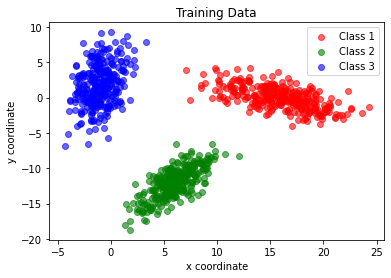

In [1241]:
# Plotting training data

plt.scatter(train1[0],train1[1],color='r',alpha=0.6,label='Class 1')
plt.scatter(train2[0],train2[1],color='g',alpha=0.6,label='Class 2')
plt.scatter(train3[0],train3[1],color='b',alpha=0.6,label='Class 3')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title("Training Data")
plt.savefig("FCNN_LS_Results\\Part1_Q1_train_data.png")
plt.plot()

# Training model

In [1242]:
# linear activation function

def linear(x):
    return x

In [1243]:
# Sigmoid activation function

def sigmoid(x,fn='logistic'):
    
    if fn=='logistic':
        return 1/(1+np.exp(-x))
    
    elif fn=='tanh':
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [1244]:
# Instantaneous error (to be calculated for each pattern)

def instant_error(y,y_pred):
    
    return (1/2)*sum((y-y_pred)**2)

In [1245]:
# Gradient of weights between output layer and hidden layer 1

def output_gradient(y,y_pred,h,eta=0.001,act_fn='logistic'):
    
    if act_fn=='logistic':
        return eta*np.outer(h,(y-y_pred)*y_pred*(1-y_pred))     #5 x 3
    
    elif act_fn=='tanh':
        return eta*np.outer(h,(y-y_pred)*(1-(y_pred**2)))

In [1246]:
# Gradient of weights between input layer and hidden layer 1

def hidden_gradient(y,y_pred,w_o,h,x,eta=0.001,act_fn='logistic'):
    
    w_o=w_o[1:,:]           # j=1 to J so we remove first row
    if act_fn=='logistic':
        return eta*np.outer(x,np.dot(w_o,(y-y_pred)*y_pred*(1-y_pred))*h*(1-h))     
    
    elif act_fn=='tanh':
        
        return eta*np.outer(x,np.dot(w_o,(y-y_pred)*(1-(y_pred**2)))*(1-h**2))

In [1247]:
def train_network(data,validation,J=4,eta=0.001,epoch=10,error_threshold=0.01,hidden_act='logistic',output_act='logistic',track_performance=False,plot_error=True):
    
    m,n=data.shape
    
    # initialize weight matrix from input to hidden layer 1 of size (d+1,J) where d is the number of features in input
    # pattern and J is number of hidden units in the first hidden layer
    
    w_h=np.random.randn(3,J)

    # initialise weight matrix between hidden layer 1 and output layer of size (J+1,K) where K is the number of classes
    
    w_o=np.random.randn(J+1,3)
    
    error=[]               # list of errors for each pattern in each epoch
    avg_error=[]           # list of average error for each epoch
    avg_e=10**5
    avg_valid_error=[]
    j=1
    while epoch!=0 and avg_e>error_threshold:
        valid_err=[];g_lst=[];s_lst=[]
        for i in range(m):
            x_n=np.array([1,data.iloc[i,0],data.iloc[i,1]])         # concatenating 1 for bias term
            x_n=linear(x_n)                                         # linear activation function at input layer
            
            a_n=np.dot(w_h.T,x_n)                                   # activation value
            g_n=sigmoid(a_n,hidden_act)                             # activation function at hidden layer 1
            h_n=np.concatenate((np.array([1]),g_n))                 # concatenating 1 for bias term
            g_lst.append(g_n)

            a_o=np.dot(w_o.T,h_n)                                   # activation value
            s_n=sigmoid(a_o,output_act)                             # activation function at output layer
            s_lst.append(s_n)

            # calculate error
            
            if i<300:
                y_n=[1,0,0]
            elif i>=300 and i<600:
                y_n=[0,1,0]
            else:
                y_n=[0,0,1]
                
            e_n=instant_error(np.array(y_n),s_n)
            error.append(e_n)
            
            # testing model on validation set
            if j==1 or j%5==0:
                y_pred,g,s=test_model(validation,w_h,w_o,hidden_act=hidden_act,output_act=output_act)
                
                # calculate validation error
                for k in range(len(y_pred)): 
                    if k<100:
                        y_k=[1,0,0]
                    elif k>=100 and i<200:
                        y_k=[0,1,0]
                    else:
                        y_k=[0,0,1]
                    if y_pred[k]==1:
                        y_p=[1,0,0]
                    elif y_pred[k]==2:
                        y_p=[0,1,0]
                    else:
                        y_p=[0,0,1]

                    err_k=instant_error(np.array(y_k),np.array(y_p))
                    valid_err.append(err_k)
        
            # Backpropagation operations
            
            w_o+=output_gradient(y_n,s_n,h_n,eta=eta,act_fn=output_act)
            w_h+=hidden_gradient(y_n,s_n,w_o,g_n,x_n,eta=eta,act_fn=hidden_act)
            
        avg_e=sum(error)/len(error)                    # average training error at each epoch
        avg_error.append(avg_e)
        if j==1 or j%5==0:
            avg_valid_err=sum(valid_err)/len(valid_err)     # average validation error at each epoch
            avg_valid_error.append(avg_valid_err)
        if track_performance==True:
            if j==1 or j%5==0:
                print("Epoch: ",j,end="\n")
                print("Train error: ",avg_e,"\t")
                print("Validation error: ",avg_valid_err)
                
        j+=1
        epoch-=1

    final_error=avg_e                 # final error after convergence
    final_valid_error=avg_valid_err   # final error after convergence

    if plot_error==True:
        plt.figure(figsize=(8,6))
        plt.plot(avg_error,label='hidden 1: '+str(J))
        plt.legend()
        plt.title("Average Error vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Average Error")
        plt.xticks(np.arange(1,len(avg_error),10))
        plt.savefig("FCNN_LS_Results\\Part1_Q1_avg_error_"+str(J)+"hidden_units_"+str(epoch)+"epochs.png")
        plt.show()
        
        plt.figure(figsize=(8,8))
        plt.plot(avg_valid_error,label='hidden 1: '+str(J))
        plt.legend()
        plt.title("Average validation error vs epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Average validation error")
        plt.xticks(np.arange(1,len(avg_valid_error)*5,5))
        plt.savefig("FCNN_LS_Results\\Part1_Q1_avg_valid_error_"+str(J)+"hidden_units_"+str(epoch)+"epochs.png")
        plt.show()
    
    return w_h,w_o,avg_error,final_error,final_valid_error,J,np.array(g_lst).T,np.array(s_lst).T

In [1248]:
# Testing unseen data

def test_model(test,w_h,w_o,hidden_act='tanh',output_act='logistic'):
    
    m,n=test.shape
    y_pred=[]           # predicted label
    g_lst=[]
    s_lst=[]
    for i in range(m):
        x_n=np.array([1,test.iloc[i,0],test.iloc[i,1]])
        x_n=linear(x_n)                                         # linear activation function at input layer

        a_n=np.dot(w_h.T,x_n)                                   # activation value
        g_n=sigmoid(a_n,hidden_act)                             # activation function at hidden layer 1
        h_n=np.concatenate((np.array([1]),g_n))                 # concatenating 1 for bias term
        g_lst.append(g_n)

        a_o=np.dot(w_o.T,h_n)                                   # activation value
        s_n=sigmoid(a_o,output_act)                             # activation function at output layer
        s_lst.append(s_n)

        max_val=np.max(s_n)
        if s_n[0]==max_val:
            y_n=1
        elif s_n[1]==max_val:
            y_n=2
        else:
            y_n=3
        
        y_pred.append(y_n)
            
    return np.array(y_pred),np.array(g_lst).T,np.array(s_lst).T

Training model...

Epoch:  1
Train error:  0.38280809597429244 	
Validation error:  0.787174074074074
Epoch:  5
Train error:  0.30113875709992094 	
Validation error:  0.3935666666666667
Epoch:  10
Train error:  0.2077180100215865 	
Validation error:  0.3700222222222222
Epoch:  15
Train error:  0.1608216866285676 	
Validation error:  0.356737037037037
Epoch:  20
Train error:  0.13277968724939482 	
Validation error:  0.3498074074074074
Epoch:  25
Train error:  0.11393175603519448 	
Validation error:  0.34074074074074073
Epoch:  30
Train error:  0.10013883859828016 	
Validation error:  0.3388888888888889
Epoch:  35
Train error:  0.08943330471028678 	
Validation error:  0.3388888888888889
Epoch:  40
Train error:  0.08080012505146827 	
Validation error:  0.3388814814814815
Epoch:  45
Train error:  0.07368253825907671 	
Validation error:  0.337037037037037
Epoch:  50
Train error:  0.06772645966669401 	
Validation error:  0.3351851851851852
Epoch:  55
Train error:  0.06268353554788257 	
Valid

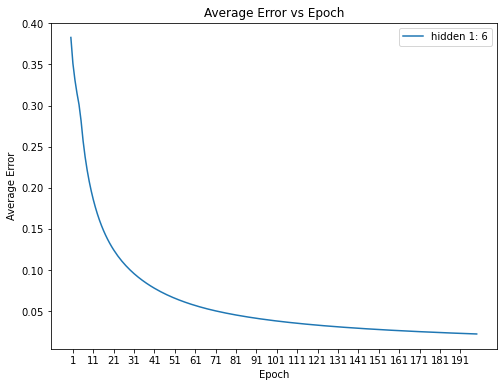

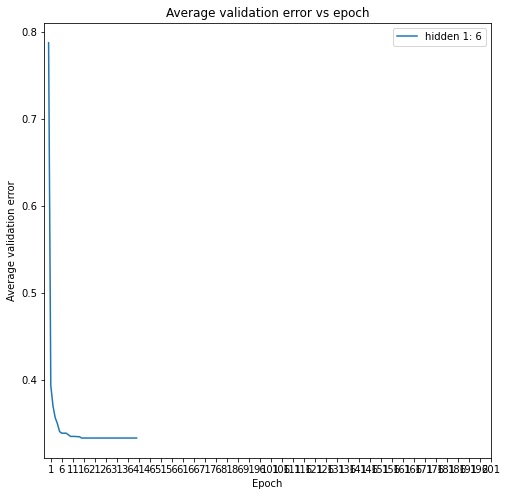

In [1249]:
# Preparing combined training data

train=train1.append(train2,ignore_index=True)
train=train.append(train3,ignore_index=True)
valid=validation1.append(validation2,ignore_index=True)
valid=valid.append(validation3,ignore_index=True)
print("Training model...\n")
w_h1,w_out,avg_err,final_err,valid_err,J,g_train,s_train=train_network(train,valid,J=6,eta=0.001,epoch=200,error_threshold=0.0001,hidden_act='tanh',output_act='logistic',track_performance=True)

In [1250]:
print('Updated parameters: \n')
print('Weight matrix for hidden layer 1: \n {} \n\n Weight vector for output layer:\n {} \n\n Train error: {} \n\n Validation error: {}'.format(w_h1,w_out,final_err,valid_err))

Updated parameters: 

Weight matrix for hidden layer 1: 
 [[ 1.01038699  1.04507771  0.6793202   2.37162256  1.58273641 -2.41789165]
 [ 0.08928618 -0.56056603  0.1914847  -0.32894668 -0.14224282 -0.14590491]
 [ 0.40466272  0.15534546 -1.14987901 -0.20414492  0.1080064   0.02378235]] 

 Weight vector for output layer:
 [[-0.7227925  -0.54737267  0.57897417]
 [ 1.28883868 -1.54924883  0.37001068]
 [ 0.13534216 -0.6869564   2.4395195 ]
 [ 0.05507254 -0.5309629   0.22185665]
 [-1.93200788  1.530645    0.5716571 ]
 [-1.83057204 -2.07481963  1.111963  ]
 [ 0.21633228  0.97205742  1.08607246]] 

 Train error: 0.02222826422312815 

 Validation error: 0.3333333333333333


# Plotting decision boundary

In [1251]:
# Plotting decision boundary
x_min=min([min(data_class1.iloc[0]),min(data_class2.iloc[0]),min(data_class2.iloc[0])])
x_max=max([max(data_class1.iloc[0]),max(data_class2.iloc[0]),max(data_class2.iloc[0])])
y_min=min([min(data_class1.iloc[1]),min(data_class2.iloc[1]),max(data_class2.iloc[1])])
y_max=max([max(data_class1.iloc[1]),max(data_class2.iloc[1]),max(data_class2.iloc[1])])

xx, yy = np.meshgrid(np.arange(x_min-15, x_max+15, 0.1), np.arange(y_min-15, y_max+15, 0.1))
meshgrid=np.c_[xx.ravel(),yy.ravel()]       # flatten meshgrid and concatenate to create points

In [1252]:
def decision_region(meshgrid,data1,data2,data3,w_h1,w_o,hidden_act='tanh',output_act='logistic'):
    
    c1=[];c2=[];c3=[]
    
    # compute output for complete mesh
    
    meshgrid=pd.DataFrame(meshgrid)
    y_pred,g,s=test_model(meshgrid,w_h1,w_o,hidden_act,output_act)
    
    m,n=meshgrid.shape

    for i in range(m):
        if y_pred[i]==1:
            c1.append((meshgrid.iloc[i,0],meshgrid.iloc[i,1]))
        elif y_pred[i]==2:
            c2.append((meshgrid.iloc[i,0],meshgrid.iloc[i,1]))    
        else:
            c3.append((meshgrid.iloc[i,0],meshgrid.iloc[i,1]))
    
    c1=np.array(c1)
    c2=np.array(c2)
    c3=np.array(c3)
    
    J=w_o.shape[0]-1
    plt.figure(figsize=(8,6))
    plt.scatter(c1[:,0],c1[:,1],color='coral',label="Region 1")
    plt.scatter(c2[:,0],c2[:,1],color='lightskyblue',label="Region 2")
    plt.scatter(c3[:,0],c3[:,1],color='pink',label="Region 3")
    plt.scatter(data1[0],data1[1],color='red',edgecolors='black',alpha=0.6,label="Class 1")
    plt.scatter(data2[0],data2[1],color='steelblue',edgecolors='black',alpha=0.6,label="Class 2")
    plt.scatter(data3[0],data3[1],color='mediumvioletred',edgecolors='black',alpha=0.6,label="Class 3")
    plt.legend(loc="best")
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')
    plt.title('Multi-class decision region.')
    plt.savefig("FCNN_LS_Results\\Part1_Q1_decision_region_"+str(J)+"hidden_units.png")
    plt.show()

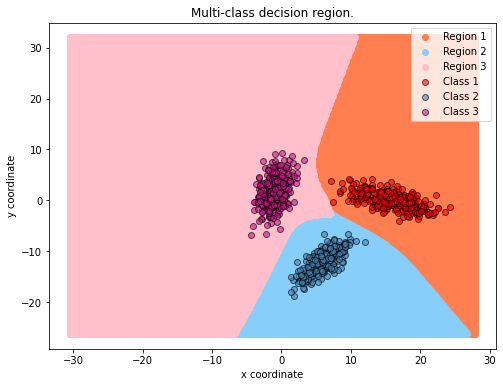

In [1253]:
decision_region(meshgrid,train1,train2,train3,w_h1,w_out,hidden_act='tanh',output_act='logistic')

# Testing model

In [1254]:
# Testing on validation data

valid_pred,g_valid,s_valid=test_model(valid,w_h1,w_out,hidden_act='tanh',output_act='logistic')

# Preparing combined test data

test=test1.append(test2,ignore_index=True)
test=test.append(test3,ignore_index=True)
print("Testing model...")
y_pred,g_test,s_test=test_model(test,w_h1,w_out,hidden_act='tanh',output_act='logistic')


Testing model...


In [1255]:
# Confusion Matrix

def confusion_matrix(y_pred):
    
    mat=np.zeros((3,3))
    
    n=int(len(y_pred)/3)
    for i in range(len(y_pred)):
        if i<n:                      # true class is 1
            if y_pred[i]==1:
                mat[0][0]+=1
            elif y_pred[i]==2:
                mat[1][0]+=1
            else:
                mat[2][0]+=1
        elif i>=n and i<2*n:         # true class is 2
            if y_pred[i]==1:
                mat[0][1]+=1
            elif y_pred[i]==2:
                mat[1][1]+=1
            else:
                mat[2][1]+=1
        else:                        # true class is 3
            if y_pred[i]==1:
                mat[0][2]+=1
            elif y_pred[i]==2:
                mat[1][2]+=1
            else:
                mat[2][2]+=1
    
    return mat.astype(int)

In [1256]:
# Classification accuracy

def accuracy(TP1,TP2,TP3,total):
    return ((TP1+TP2+TP3)/total)*100

In [1257]:
# Precision for a classifier

def precision(TP,FP):
    return TP/(TP+FP)

In [1258]:
# recall for a classifier

def recall(TP,FN):
    return TP/(TP+FN)

In [1259]:
# F-measure of a classifier

def f_measure(precision,recall):
    return 2*precision*recall/(precision+recall)

# Performance measures on validation data

In [1260]:
conf_mat_valid=confusion_matrix(valid_pred)
print("Confusion Matrix for validation data")
print(conf_mat_valid)
acc_valid=accuracy(conf_mat_valid[0][0],conf_mat_valid[1][1],conf_mat_valid[2][2],len(valid_pred))
print("Accuracy of model: ",acc_valid)

Confusion Matrix for validation data
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]
Accuracy of model:  100.0


# Performance measures on test data

In [1261]:
conf_mat=confusion_matrix(y_pred)

In [1262]:
print("Confusion Matrix for 3-class classification")
print(conf_mat)

Confusion Matrix for 3-class classification
[[100   0   0]
 [  0 100   0]
 [  0   0 100]]


In [1263]:
acc=accuracy(conf_mat[0][0],conf_mat[1][1],conf_mat[2][2],len(y_pred))
print("Accuracy of model: ",acc)

Accuracy of model:  100.0


In [1264]:
precision1=precision(conf_mat[0][0],conf_mat[0][1]+conf_mat[0][2])
precision2=precision(conf_mat[1][1],conf_mat[1][0]+conf_mat[1][2])
precision3=precision(conf_mat[2][2],conf_mat[2][0]+conf_mat[2][1])
precision_lst=[precision1,precision2,precision3]

In [1265]:
for i in range(len(precision_lst)):
    print('Precision for class '+str(i+1)+': ',precision_lst[i])
    
print("Average precision: ",(np.mean(precision_lst)))

Precision for class 1:  1.0
Precision for class 2:  1.0
Precision for class 3:  1.0
Average precision:  1.0


In [1266]:
recall1=recall(conf_mat[0][0],conf_mat[1][0]+conf_mat[2][0])
recall2=recall(conf_mat[1][1],conf_mat[0][1]+conf_mat[2][1])
recall3=recall(conf_mat[2][2],conf_mat[0][2]+conf_mat[1][2])
recall_lst=[recall1,recall2,recall3]

In [1267]:
for i in range(len(recall_lst)):
    print('Recall for class '+str(i+1)+': ',recall_lst[i])
    
print("Average recall: ",(np.mean(recall_lst)))

Recall for class 1:  1.0
Recall for class 2:  1.0
Recall for class 3:  1.0
Average recall:  1.0


In [1268]:
f1=f_measure(precision1,recall1)
f2=f_measure(precision2,recall2)
f3=f_measure(precision3,recall3)
f_lst=[f1,f2,f3]

In [1269]:
for i in range(len(f_lst)):
    print('F-measure for class '+str(i+1)+': ',recall_lst[i])
    
print("Average f-measure: ",(np.mean(f_lst)))

F-measure for class 1:  1.0
F-measure for class 2:  1.0
F-measure for class 3:  1.0
Average f-measure:  1.0


# 3D plots for hidden and output unit results on training, validation and test data

In [1270]:
from mpl_toolkits.mplot3d import Axes3D

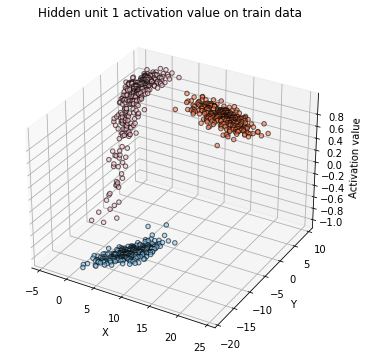

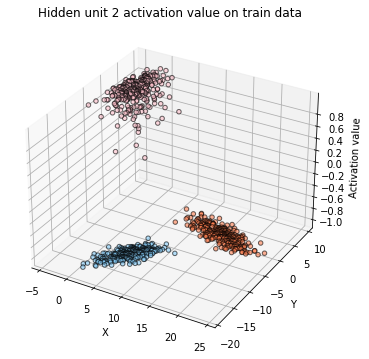

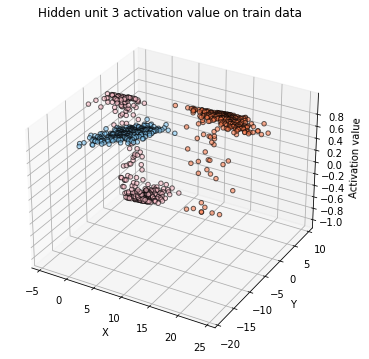

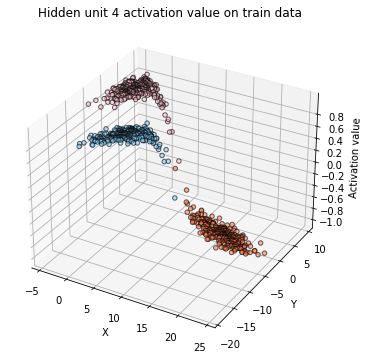

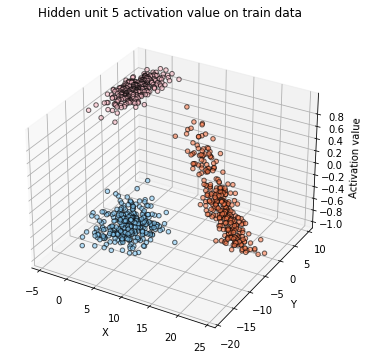

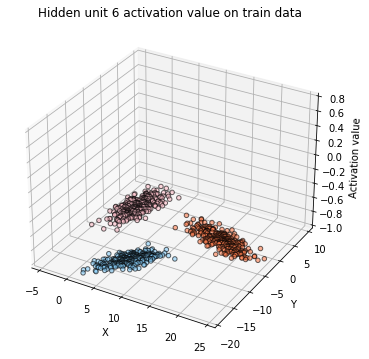

In [1271]:
# plotting hidden units activation value on training data

m1,n1=g_train.shape
for i in range(m1):
    Z=g_train[i]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(train[0][:300],train[1][:300], Z[:300], c='coral',alpha=0.6,edgecolors='black')
    ax.scatter(train[0][301:600],train[1][301:600], Z[301:600], c='lightskyblue',alpha=0.6,edgecolors='black')
    ax.scatter(train[0][601:],train[1][601:], Z[601:],c='pink',alpha=0.6,edgecolors='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Activation value')
    ax.set_title(f'Hidden unit {i+1} activation value on train data')
    ax.set_zticks(np.arange(-1,1,0.2))
    plt.savefig("FCNN_LS_Results\\Part1_Q1_"+str(i+1)+"hidden_neuron_train_"+str(J)+".png")
    plt.show()

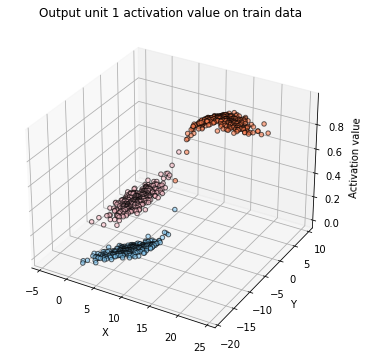

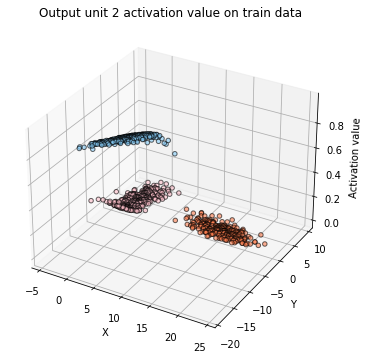

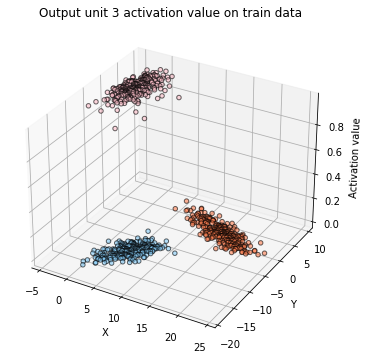

In [1272]:
# plotting output units activation value on training data

m1,n1=s_train.shape
for i in range(m1):
    Z=s_train[i]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(train[0][:300],train[1][:300], Z[:300], c='coral',alpha=0.6,edgecolors='black')
    ax.scatter(train[0][301:600],train[1][301:600], Z[301:600], c='lightskyblue',alpha=0.6,edgecolors='black')
    ax.scatter(train[0][601:],train[1][601:], Z[601:],c='pink',alpha=0.6,edgecolors='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Activation value')
    ax.set_zticks(np.arange(0,1,0.2))
    ax.set_title(f'Output unit {i+1} activation value on train data')
    plt.savefig("FCNN_LS_Results\\Part1_Q1_"+str(i+1)+"output_neuron_train_"+str(J)+".png")
    plt.show()

In [1273]:
valid_pred,g_valid,s_valid=test_model(valid,w_h1,w_out,hidden_act='tanh',output_act='logistic')

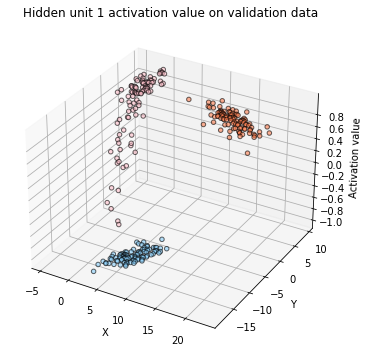

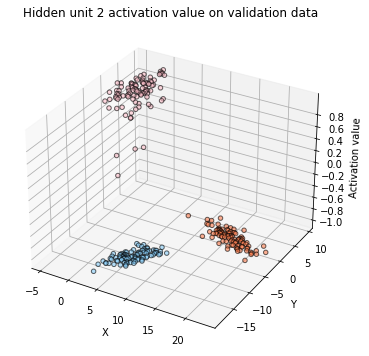

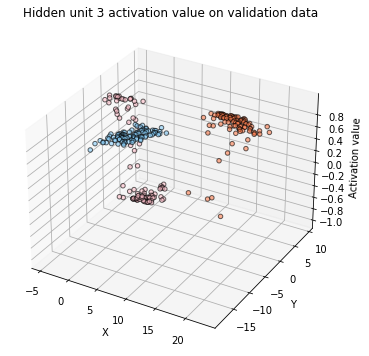

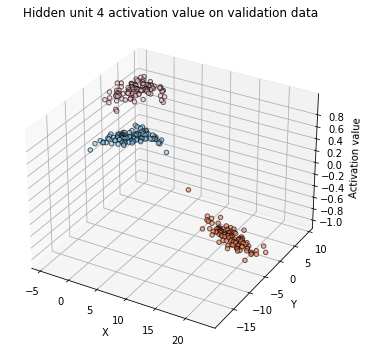

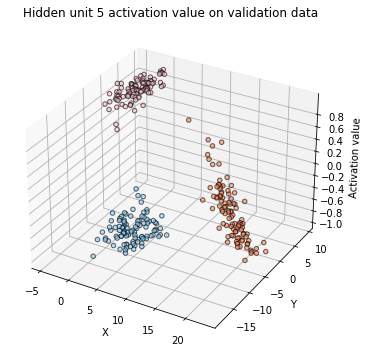

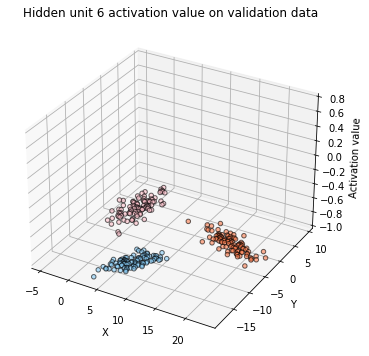

In [1274]:
# plotting hidden units activation value on validation data

m1,n1=g_valid.shape
for i in range(m1):
    Z=g_valid[i]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(valid[0][:100],valid[1][:100], Z[:100], c='coral',alpha=0.6,edgecolors='black')
    ax.scatter(valid[0][101:200],valid[1][101:200], Z[101:200], c='lightskyblue',alpha=0.6,edgecolors='black')
    ax.scatter(valid[0][201:],valid[1][201:], Z[201:],c='pink',alpha=0.6,edgecolors='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Activation value')
    ax.set_zticks(np.arange(-1,1,0.2))
    ax.set_title(f'Hidden unit {i+1} activation value on validation data')
    plt.savefig("FCNN_LS_Results\\Part1_Q1_"+str(i+1)+"hidden_neuron_valid_"+str(J)+".png")
    plt.show()

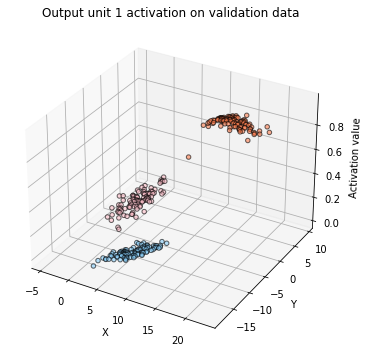

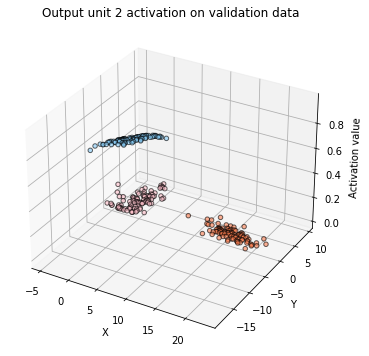

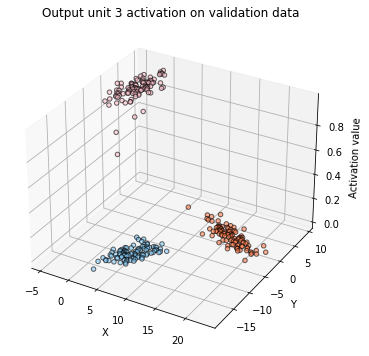

In [1275]:
# plotting output units activation value on validation data

m1,n1=s_valid.shape
for i in range(m1):
    Z=s_valid[i]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(valid[0][:100],valid[1][:100], Z[:100], c='coral',alpha=0.6,edgecolors='black')
    ax.scatter(valid[0][101:200],valid[1][101:200], Z[101:200], c='lightskyblue',alpha=0.6,edgecolors='black')
    ax.scatter(valid[0][201:],valid[1][201:], Z[201:],c='pink',alpha=0.6,edgecolors='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Activation value')
    ax.set_zticks(np.arange(0,1,0.2))
    ax.set_title(f'Output unit {i+1} activation on validation data')
    plt.savefig("FCNN_LS_Results\\Part1_Q1_"+str(i+1)+"output_neuron_valid_"+str(J)+".png")
    plt.show()

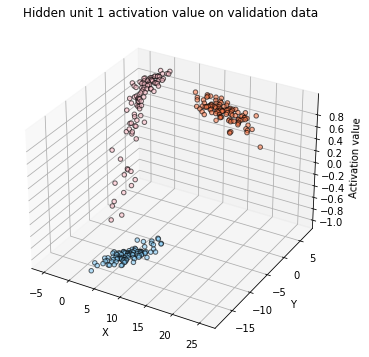

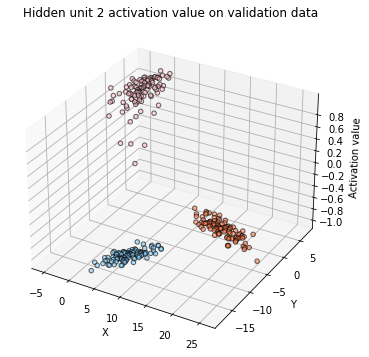

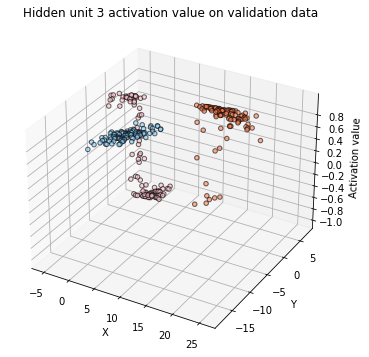

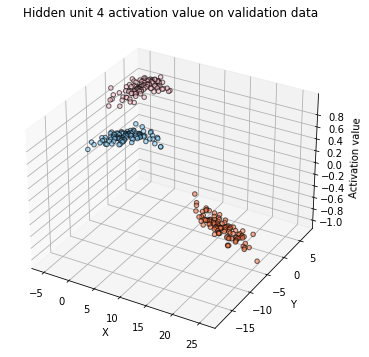

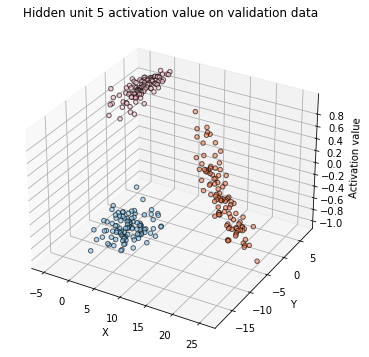

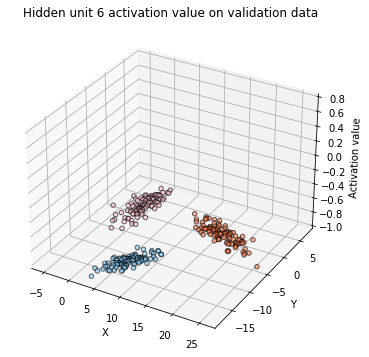

In [1276]:
# plotting hidden units activation value on test data

m1,n1=g_test.shape
for i in range(m1):
    Z=g_test[i]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(test[0][:100],test[1][:100], Z[:100], c='coral',alpha=0.6,edgecolors='black')
    ax.scatter(test[0][101:200],test[1][101:200], Z[101:200], c='lightskyblue',alpha=0.6,edgecolors='black')
    ax.scatter(test[0][201:],test[1][201:], Z[201:],c='pink',alpha=0.6,edgecolors='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Activation value')
    ax.set_title(f'Hidden unit {i+1} activation value on validation data')
    ax.set_zticks(np.arange(-1,1,0.2))
    plt.savefig("FCNN_LS_Results\\Part1_Q1_"+str(i+1)+"hidden_neuron_test_"+str(J)+".png")
    plt.show()

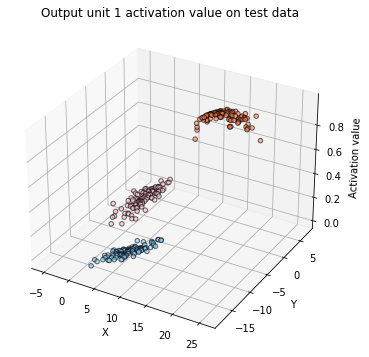

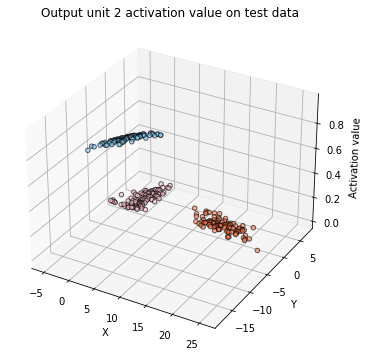

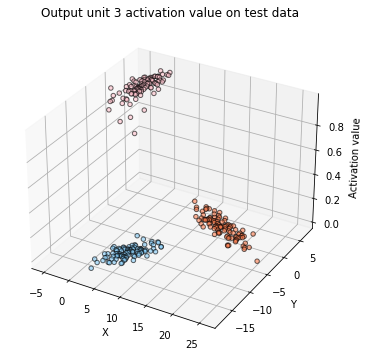

In [1277]:
# plotting output units activation value on test data

m1,n1=s_test.shape
for i in range(m1):
    Z=s_test[i]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(test[0][:100],test[1][:100], Z[:100], c='coral',alpha=0.6,edgecolors='black')
    ax.scatter(test[0][101:200],test[1][101:200], Z[101:200], c='lightskyblue',alpha=0.6,edgecolors='black')
    ax.scatter(test[0][201:],test[1][201:], Z[201:],c='pink',alpha=0.6,edgecolors='black')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Activation value')
    ax.set_title(f'Output unit {i+1} activation value on test data')
    ax.set_zticks(np.arange(0,1,0.2))
    plt.savefig("FCNN_LS_Results\\Part1_Q1_"+str(i+1)+"output_neuron_test_"+str(J)+".png")
    plt.show()